## 3. PyCBC Tutorial: Generating Waveforms and Matched Filtering

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. We present how to generate the waveform of a gravitational-wave merger and matched filtering, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Guassian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

#### Getting the software environment setup

PyCBC is installable through pip, but also relies on portions of the [LALSuite](https://git.ligo.org/lscsoft/lalsuite) c-library. A bundled version of this suitable for use with PyCBC is also available on Mac / Linux through pip. These can be installed as follows within the notebook.

In [1]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir

     |████████████████████████████████| 8.5 MB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 202 kB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 48.1 MB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 25.1 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 78 kB 11.4 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 12.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pegasus-wms.api: filename=pegasus_wms.api-5.0.8-py3-none-any.whl size=50502 sha256=841d7b60fe315c5a3390b4e500951da874e9a4428e5c6ccd05e80b7061544e8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-45n4e63_/wheels/52/12/ea/115dfca572b1eb09ac684ecb9

### Generate your first waveform !

Here we'll generate the gravitational waveform using one of the available waveform approximants. These can be generated as a time series using [`get_td_waveform`](http://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform). There are some additional examples using this interface [here](http://pycbc.org/pycbc/latest/html/waveform.html). The key parameters are the masses of the binary (given in solar masses), the time between samples (in seconds), the starting gravitational-wave frequency (Hz) and the name of the approximant we'd like to generate. A variety of approximants are available that include different physical effects. A full review of the different models is outside of the scope of this tutorial.

In this example, we've chosen to use the 'SEOBNRv4_opt' model. There are many others available as well with different methodologies and which include different physical effects. This is an implementation of the model introduced [in this paper](https://arxiv.org/pdf/1611.03703.pdf). It models the gravitational waveform of inspiralling and merging black holes, and includes the ability for each black hole to spin in the same direction as the orbit (aligned spin).

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


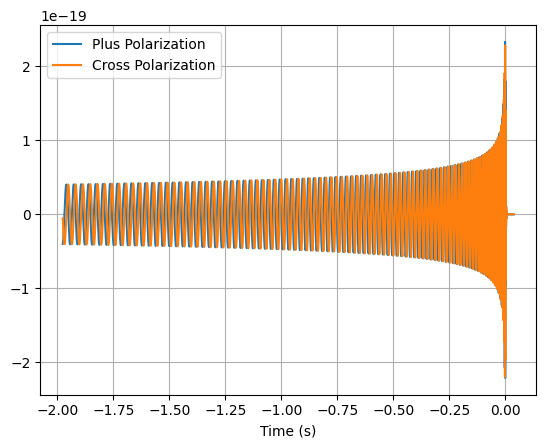

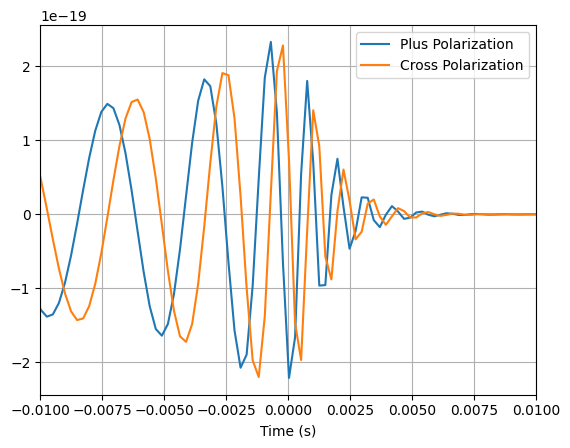

In [1]:
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

We can see that in the this case, the two polariations differ only by the phase of the signal. This holds for systems where the orbital plane of the binary doesn't precess. In the zoom-in plot, we can see the merger itself and the ringdown that follows.

### How does the waveform change with the mass of the binary?

Below you can see how the length of the waveform increases for lower mass binary mergers.

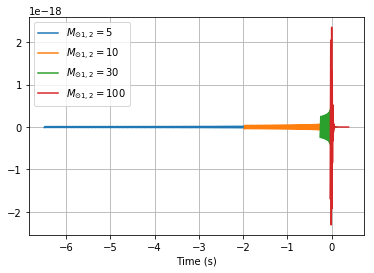

In [3]:
# Component mass of each binary component. We'll simplify here and assume that each 
# component of the binary has the same mass. Again, units are in solar masses.
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)
    
    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### Changing the distance of the waveform

The distance of the waveform is also selectable when you generate a waveform. The units used are Megaparsecs. Keep in mind that no redshift effects are taken into account here, so there is a simple linear relationship between distance and amplitude

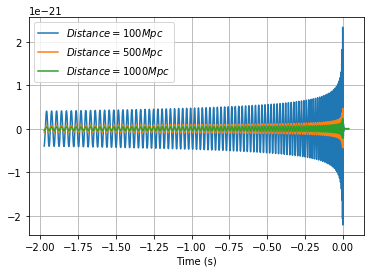

In [4]:
for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    pylab.plot(hp.sample_times, hp, label='$Distance=%sMpc$' % d)
pylab.legend()
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

### Looking for a specific signal in the data

If you know what signal you are looking for in the data, then matched filtering is known to be the optimal method in Gaussian noise to extract the siganl. Even when the parameters of the signal are unkown,  one can test for each set of parameters one is interesting in finding.

#### preconditioning the data 
 
The purpose of this is to reduce the dynamic range of the data and  supress low freqeuncy behavior which can introduce numerical artefacts. We may also wish to resample the data if high frequency content is not important.

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


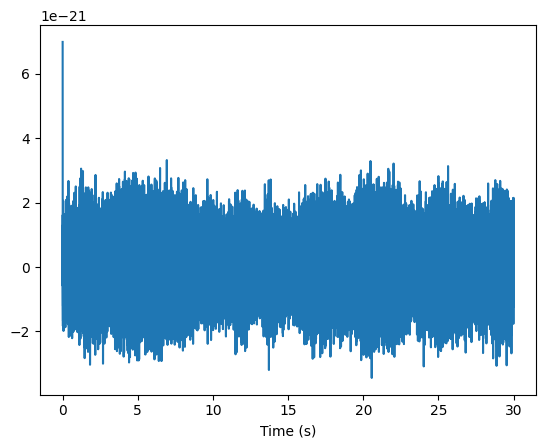

In [1]:
# As an example we use the GW150914 data
import pycbc
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
import pandas as pd
import numpy as np

%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
#merger = Merger("GW190412")

# Get the data from the Hanford detector
#strain = merger.strain('H1')

df = pd.read_csv('det3.csv')

ts = pycbc.types.timeseries.TimeSeries(np.array(df.x), df.t[100]-df.t[99])

strain=ts

# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

#### filter wraparound 

Note the spike in the data at the boundaries. This is caused by the highpass and resampling stages filtering the data. When the filter is applied to the boundaries, it wraps around to the beginning of the data. Since the data itself has a discontinuity (i.e. it is not cyclic) the filter itself will ring off for a time up to the length of the filter. 

Even if a visible transient is not seen, we want to avoid filters that act on times which are not causally connect. To avoid this we trim the ends of the data sufficiently to ensure that they do not wraparound the input. We will enforce this requirement in all steps of our filtering.

In [2]:
def binplot(x, y, x1, x2, n, color='cornflowerblue'):
    y = np.array(y)
    x = np.array(x)
    xmid = [x1 + (i+0.5)*(x2 - x1)/n for i in range(n)]
    yarr = []
    for m in xmid:
        ynew = y[np.where(np.abs(x - m) <= (x2-x1)/2/n)]
        yarr.append(np.mean(ynew))
    #print(xmid,yarr)   
    pylab.plot(xmid, yarr, color=color)
    #plt.show()

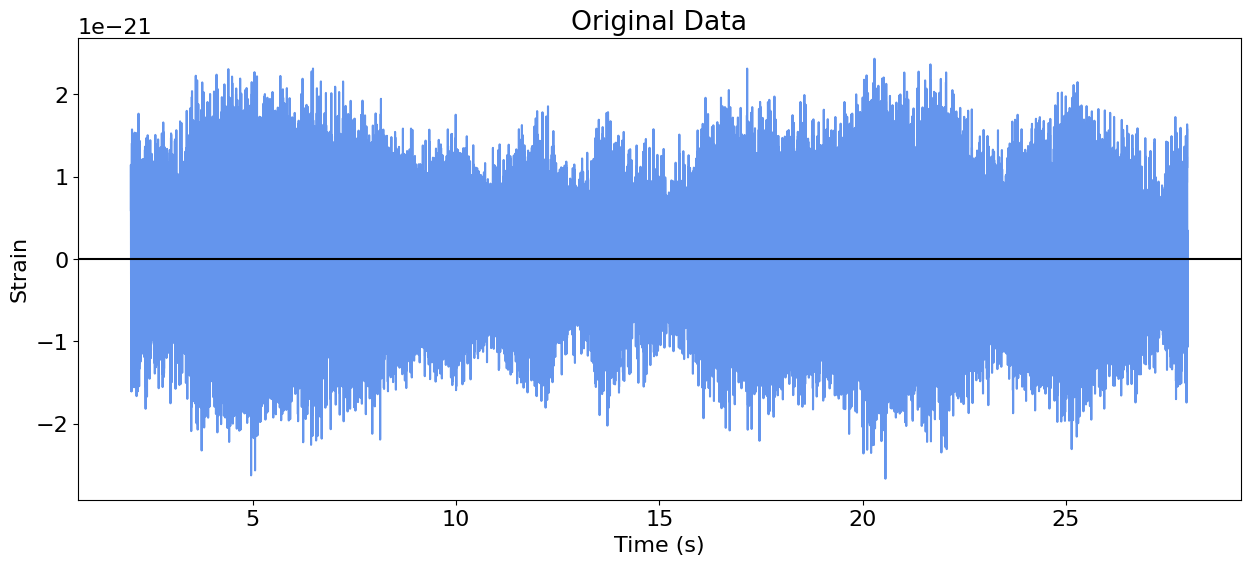

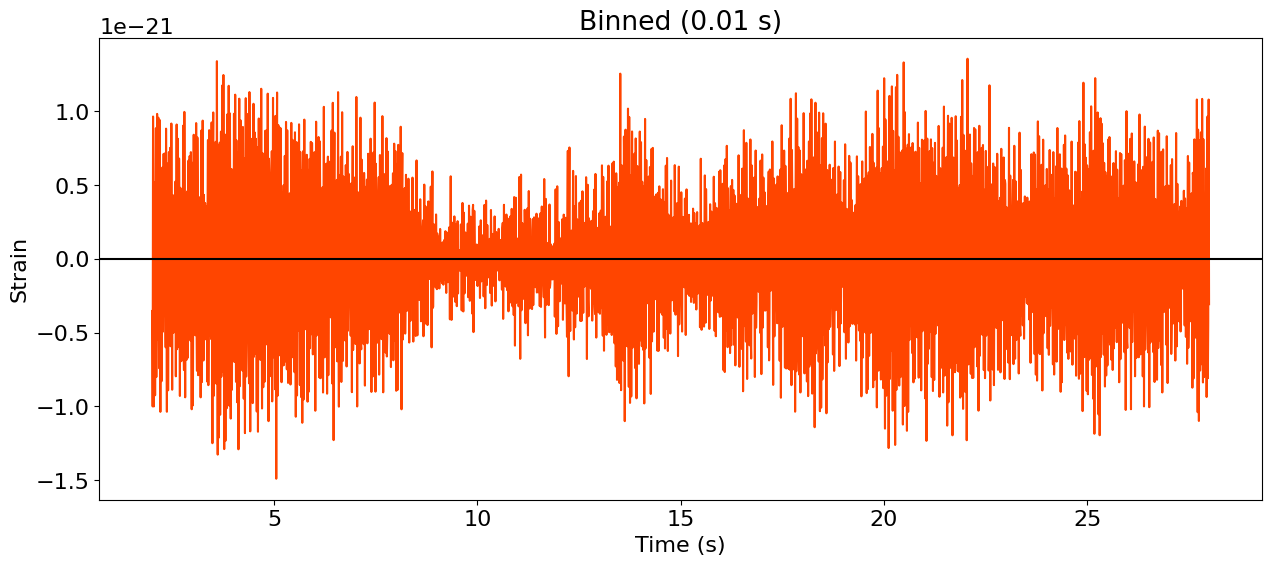

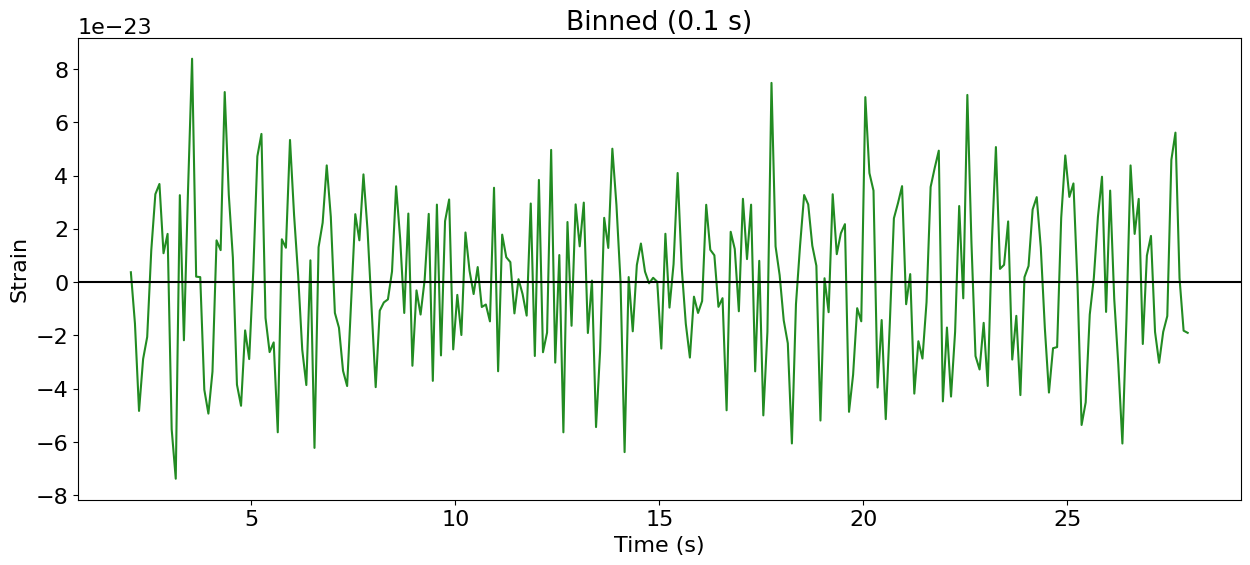

In [3]:
# Remove 2 seconds of data from both the beginning and end
pylab.rc('font', size=16)
#pylab.rc('labels', size=16)
conditioned = strain.crop(2, 2)

pylab.figure(figsize=(15,6))
binplot(conditioned.sample_times, conditioned, 2, 28, len(conditioned))
#pylab.plot(conditioned.sample_times[::100], conditioned[::100])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Original Data')
pylab.axhline([0], color='k', lw=1.5)
pylab.show()


pylab.figure(figsize=(15,6))
binplot(conditioned.sample_times, conditioned, 2, 28, 26*100, 'orangered')
#pylab.plot(conditioned.sample_times[::100], conditioned[::100])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Binned (0.01 s)')
pylab.axhline([0], color='k', lw=1.5)
pylab.show()

pylab.figure(figsize=(15,6))
binplot(conditioned.sample_times, conditioned, 2, 28, 26*10, 'forestgreen')
#pylab.plot(conditioned.sample_times[::100], conditioned[::100])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.title('Binned (0.1 s)')
pylab.axhline([0], color='k', lw=1.5)
pylab.show()

(5.0, 5.4)

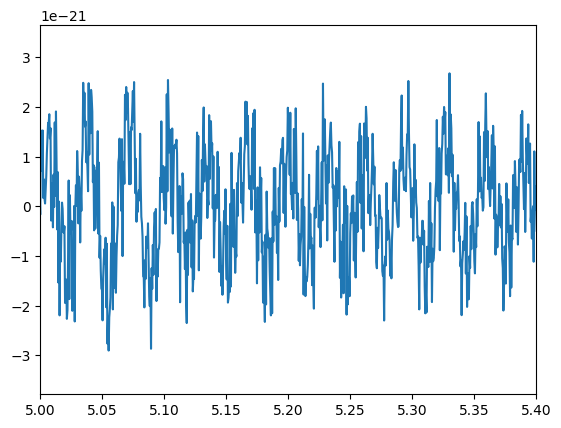

In [25]:
pylab.plot(conditioned.sample_times, conditioned)
pylab.xlim(5,5.4)

In [26]:
?conditioned.whiten

/tmp/ipykernel_163/1351564525.py:4: RuntimeWarning: invalid value encountered in sqrt
  ax[0].pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
/tmp/ipykernel_163/1351564525.py:14: RuntimeWarning: invalid value encountered in sqrt
  ax[1].pcolormesh(t, f, p**0.5, vmin=0, vmax=5)


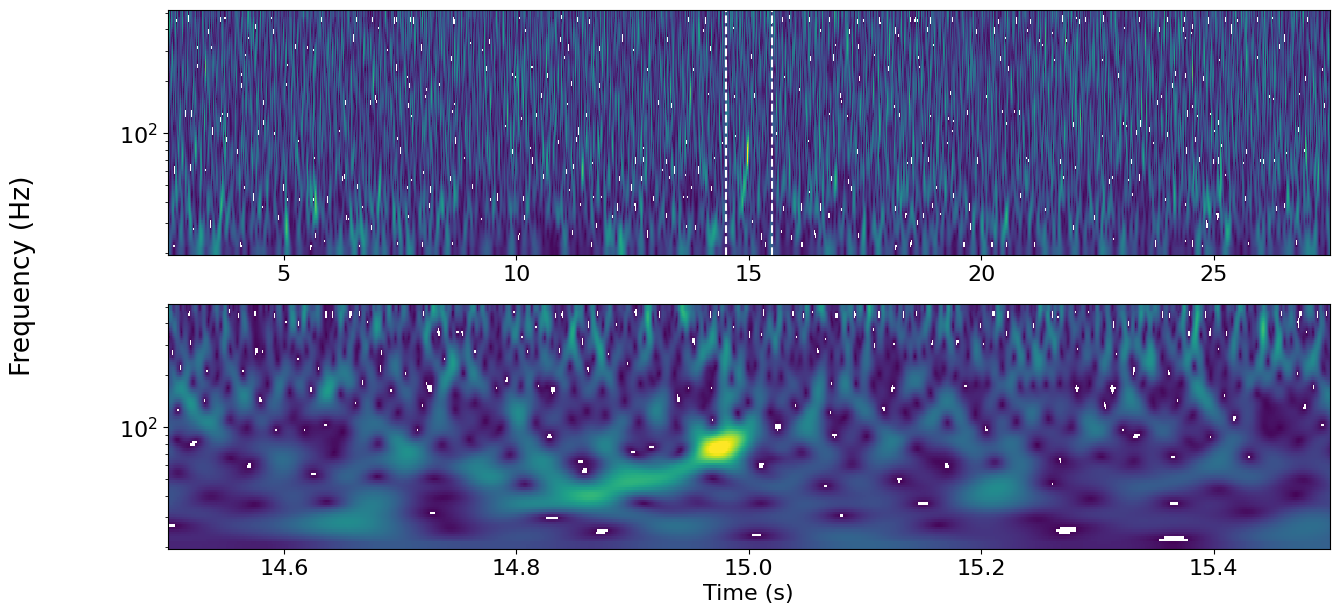

In [4]:
t, f, p = conditioned.whiten(4/4, 4/4).qtransform(.001, logfsteps=100, qrange=(8, 8), frange=(20, 512))

fig, ax = pylab.subplots(2,1,figsize=[15, 7])
ax[0].pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
ax[0].set_yscale('log')
#ax[0].set_xlabel('Time (s)')
fig.supylabel('Frequency (Hz)')
ax[0].axvline([14.5], color='w', ls='--')
ax[0].axvline([15.5], color='w', ls='--')
#time = 2.7
#pylab.xlim(14.5,15ax[1]pylab.show()

#ax[1].figure(figsize=[15, 3])
ax[1].pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (s)')
#ax[1].set_ylabel('Frequency (Hz)')
#time = 2.7
ax[1].set_xlim(14.5,15.5)
pylab.show()

/tmp/ipykernel_226/2339330493.py:8: RuntimeWarning: invalid value encountered in sqrt
  newp = p.reshape(-1, t.shape[0])**0.5


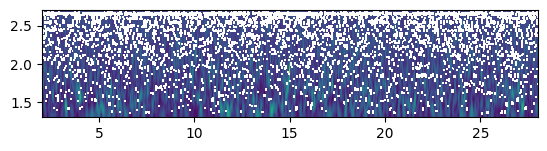

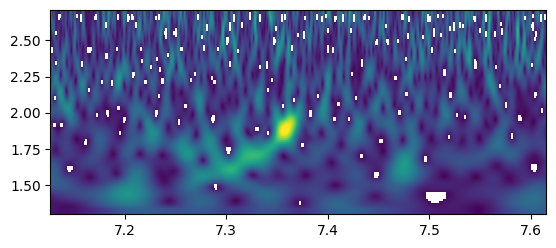

In [13]:
import matplotlib.pyplot as plt

t, f, p = conditioned.whiten(4, 4).qtransform(.001,
                                        logfsteps=100,
                                        qrange=(8, 8),
                                        frange=(20, 512))

newp = p.reshape(-1, t.shape[0])**0.5
t0 = 0
plt.imshow(newp[:,0:-1], aspect=4, origin='lower', vmax=5, extent = [conditioned.sample_times[0]-t0, conditioned.sample_times[-1]-t0, np.log10(20), np.log10(512)])
plt.show()
plt.imshow(newp[:,10500:11500], aspect=1/7, origin='lower', vmax=5, extent = [conditioned.sample_times[10500]-t0, conditioned.sample_times[11500]-t0, np.log10(20), np.log10(512)])

#### calculate the power spectral density

Optimal matched filtering requires weighting the frequency components of the potential signal and data by the noise amplitude. We can view this as filtering the data with the time series equivelant of 1 / PSD. To ensure that we can control how much applying this filter to the data, we window the time domain equivelant of the PSD to a specific length. This has effect of losing some information about line behavior in the detector, however, since our signal span a large frequency range, and lines are narrow, this is a negligible effect.

In [31]:
?pycbc.psd.welch

(20, 1024)

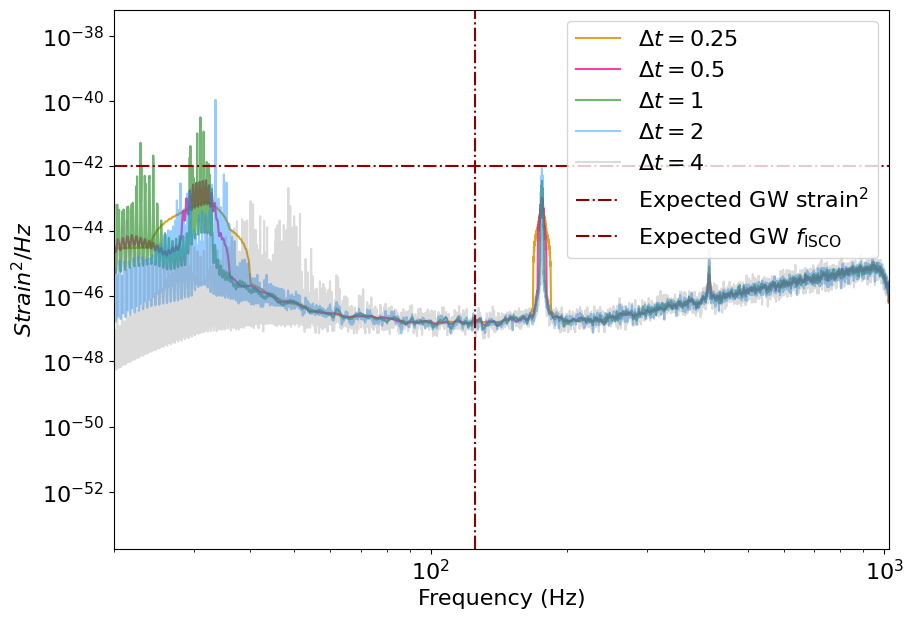

In [36]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(0.5)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
#

a = 1

colors = ['goldenrod', 'deeppink', 'forestgreen', 'dodgerblue', 'grey']

pylab.figure(figsize=(10,7))
i = 0
for window in [0.25, 0.5, 1, 2, 4]:
    psd = conditioned.psd(window)
    psd = interpolate(psd, conditioned.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)

    pylab.loglog(psd.sample_frequencies, psd, alpha=a, color=colors[i], label='$\Delta t={}$'.format(str(window)))
    i += 1
    a -= 0.18
#pylab.loglog(psd.sample_frequencies, psd)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.axhline([1e-42], color='darkred', linestyle='-.', label='Expected GW strain$^2$')
pylab.axvline([125], color='darkred', linestyle='-.', label='Expected GW $f_\mathrm{ISCO}$')
pylab.legend()
pylab.xlim(20, 1024)

In [32]:
from pycbc.filter import matched_filter
import numpy
from pycbc.waveform import get_td_waveform

n=5

peaks = np.zeros((10*n,10*n))
arr = np.zeros((10*n,10*n))
tpeaks = np.zeros((10*n, 10*n))

#psd = conditioned.psd(1)
window = 1
psd = conditioned.psd(window)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)


for i in range(10*n):
    m1 = i/n + 20
    for j in range(i,10*n):
        m2 = j/n + 20
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)

        snr = matched_filter(template, conditioned,
                      psd=psd, low_frequency_cutoff=20)
        snr = snr.crop(4 + 4, 4)
        '''
        pylab.figure(figsize=[10, 4])
        pylab.plot(snr.sample_times, abs(snr))
        pylab.ylabel('Signal-to-noise')
        pylab.xlabel('Time (s)')
        pylab.title(f'{m1} and {m2}')
        pylab.show()
        '''
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]
        
        snr = np.abs(snr)
        rms = np.mean(snr**2) - np.mean(snr)**2
        
        peaks[i,j] = peaks[j,i] = (snr[peak])
        arr[i,j] = arr[j,i] = rms
        tpeaks[i,j] = tpeaks[j,i] = time

        print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17


In [35]:
np.save('tpeaks.npy', tpeaks)
np.save('peaks.npy', peaks)
np.save('arr.npy', arr)

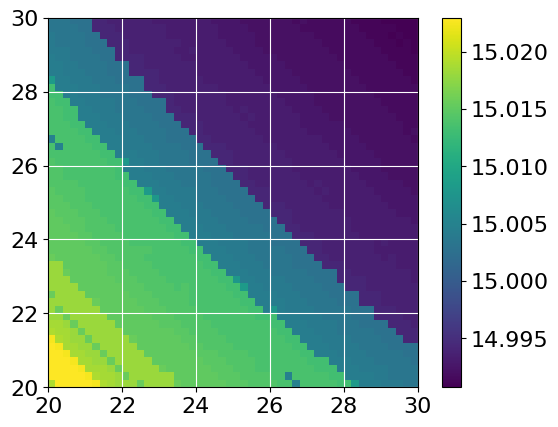

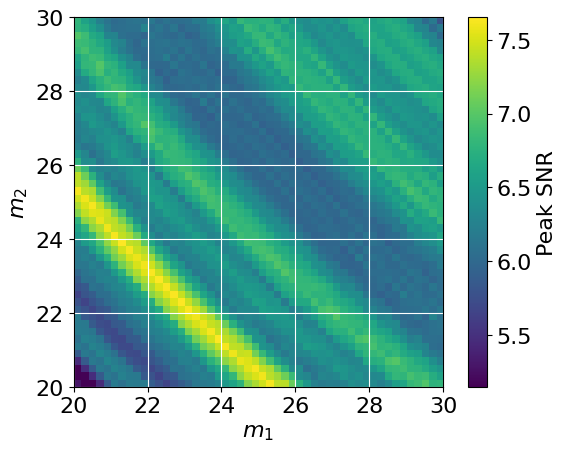

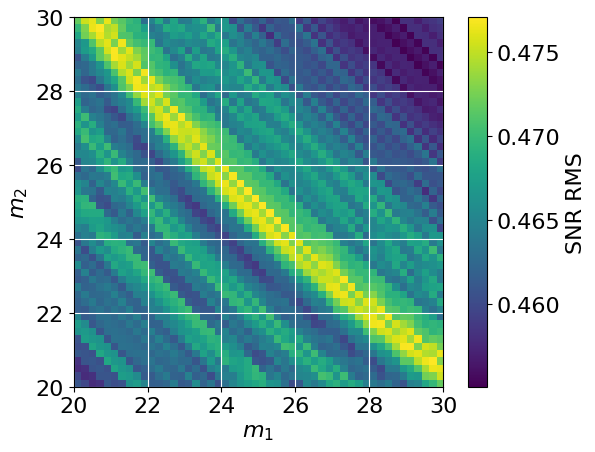

In [6]:
import matplotlib.pyplot as plt


tpeaks = np.load('tpeaks.npy')
peaks = np.load('peaks.npy')
arr = np.load('arr.npy')

plt.imshow(tpeaks, extent=[20,30,20,30], origin='lower')
plt.colorbar()
plt.grid(color='w', which='both')
plt.show()

plt.imshow(peaks, extent=[20,30,20,30], origin='lower')
plt.colorbar(label='Peak SNR')
plt.grid(color='w', which='both')
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.show()

plt.imshow(arr, extent=[20,30,20,30], origin='lower')
plt.colorbar(label='SNR RMS')
plt.grid(color='w', which='both')
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.show()

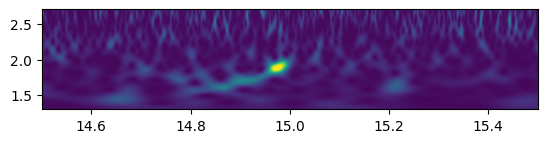

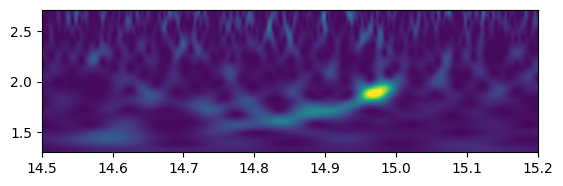

/tmp/ipykernel_268/1611692097.py:23: RuntimeWarning: invalid value encountered in sqrt
  pylab.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)


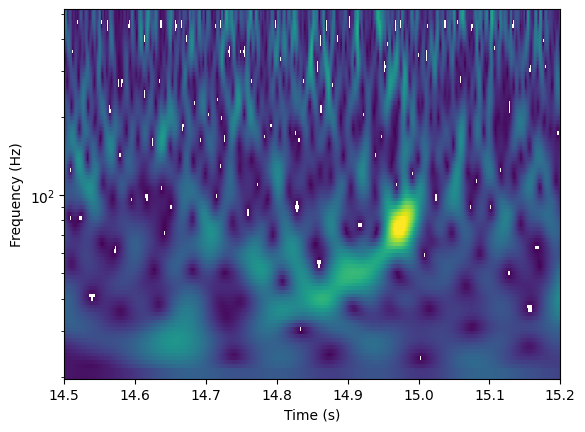

In [83]:



t, f, p = conditioned.whiten(4, 4).qtransform(.001,
                                        logfsteps=100,
                                        qrange=(8, 8),
                                        frange=(20, 512))

newp = (p.reshape(f.shape[0], t.shape[0]))

t0= 0
plt.imshow(newp[:,10500:11500], aspect=1/7, origin='lower', vmax=25, extent = [t[10500]-t0, t[11500]-t0, np.log10(20), np.log10(512)])
#plt.xlim(7,7.5)
plt.show()
plt.imshow(newp, aspect=1/7, origin='lower', vmax=25, extent = [conditioned.sample_times[0]-t0, np.array(conditioned.sample_times)[-1]-t0, np.log10(20), np.log10(512)])
plt.xlim(14.5,15.2)
plt.show()


t, f, p = conditioned.whiten(4, 4).qtransform(.001,
                                        logfsteps=100,
                                        qrange=(8, 8),
                                        frange=(20, 512))


pylab.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
pylab.yscale('log')
pylab.xlabel('Time (s)')
pylab.ylabel('Frequency (Hz)')
#time = 2.7
pylab.xlim(14.5,15.2)
pylab.show()

In [8]:
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation
import numpy
from pycbc.waveform import get_td_waveform
from pycbc.filter import sigma
from pycbc.filter import matched_filter
import numpy
from pycbc.waveform import get_td_waveform
t0 =0 

n=5

peaks = np.zeros((10*n,10*n))
chisq = np.zeros((10*n,10*n))
arr = np.zeros((10*n,10*n))
tpeaks = np.zeros((10*n, 10*n))

#psd = conditioned.psd(1)
window = 1
psd = conditioned.psd(window)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)


for i in range(10*n):
    m1 = i/n + 20
    for j in range(i,10*n):
        m2 = j/n + 20
        hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
        hp.resize(len(conditioned))
        template = hp.cyclic_time_shift(hp.start_time)

        snr = matched_filter(template, conditioned,
                      psd=psd, low_frequency_cutoff=20)
        snr = snr.crop(4 + 4, 4)
        
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]
        
        snr = np.abs(snr)
        rms = np.mean(snr**2) - np.mean(snr)**2
        
        peaks[i,j] = peaks[j,i] = (snr[peak])
        arr[i,j] = arr[j,i] = rms
        tpeaks[i,j] = tpeaks[j,i] = time

        dt = time - conditioned.start_time
        aligned = template.cyclic_time_shift(dt)
        aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)
        aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
        aligned.start_time = conditioned.start_time
        white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

        tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
        white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

        white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
        white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)
        
        time = 15
        white_data = np.array(white_data.time_slice(time-.3, time+.1))
        white_template = np.array(white_template.time_slice(time-.3, time+.1))
        
        chisq[i,j] = chisq[j,i] = np.sum( (white_data - white_template)**2 ) /len(white_data)
        
        print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
3 20
3 21
3 22
3 23
3 24
3 25
3 26
3 27
3 28
3 29
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17


In [11]:
#np.save('chisq.npy', chisq)

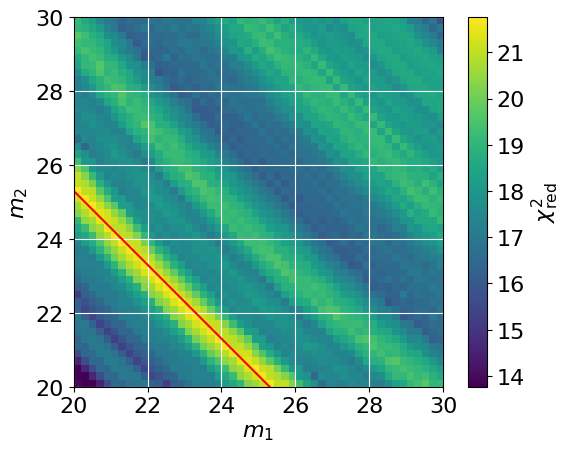

In [49]:
import matplotlib.pyplot as plt
plt.imshow(1/(chisq/len(white_data)/peaks), extent=[20,30,20,30], origin='lower', cmap='viridis')#, vmin=21.3)
#plt.imshow(chisq/len(white_data), extent=[20,30,20,30], origin='lower', cmap='viridis')
plt.colorbar(label='$\chi^2_{\mathrm{red}}$')
plt.plot([20,25.3],[25.3,20],color='red')
plt.grid(color='w', which='both')
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.show()

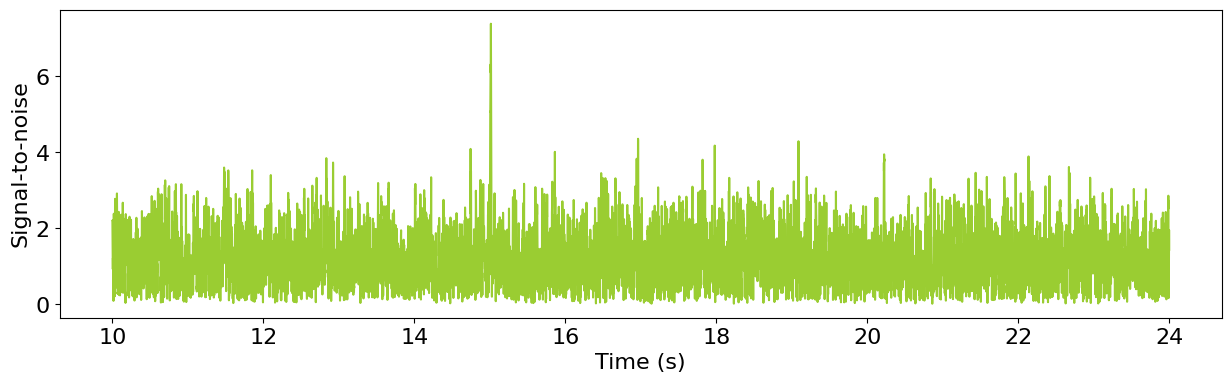

15.01416015625


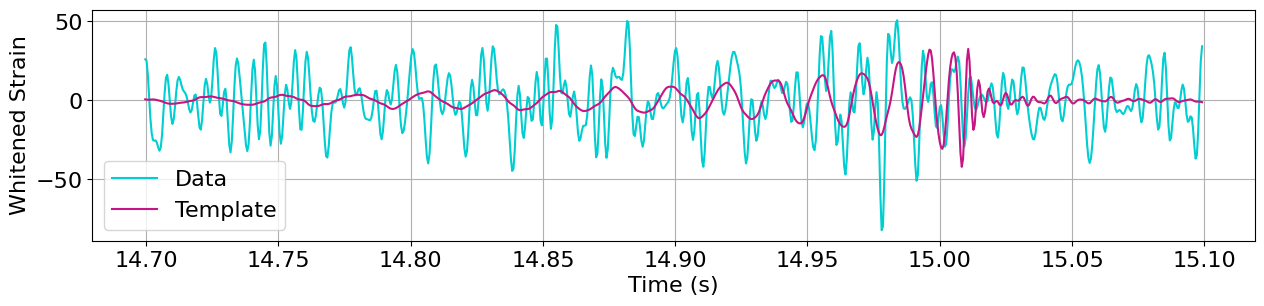

In [46]:
from pycbc.filter import sigma
from pycbc.filter import matched_filter
import numpy
from pycbc.waveform import get_td_waveform
t0 =0 

window = 1
psd = conditioned.psd(window)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate), low_frequency_cutoff=15)


m1,m2 = 22.65 , 22.65
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=conditioned.delta_t,
                     f_lower=20)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

snr = matched_filter(template, conditioned,
                      psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)
pylab.figure(figsize=[15, 4])
pylab.plot(snr.sample_times, abs(snr), color='yellowgreen')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
#pylab.title(f'{m1} and {m2}')
pylab.show()
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print(time)
#time = 15
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time


# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

time = 15
# Select the time around the merger
white_data = white_data.time_slice(time-.3, time+.1)
white_template = white_template.time_slice(time-.3, time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times-t0, white_data, label="Data", color='darkturquoise')
pylab.plot(white_template.sample_times-t0, white_template, label="Template", color='mediumvioletred')
#pylab.axhline([0], color='k', ls='dotted')
pylab.xlabel('Time (s)')
pylab.ylabel('Whitened Strain')
pylab.legend()
pylab.grid()
pylab.show()

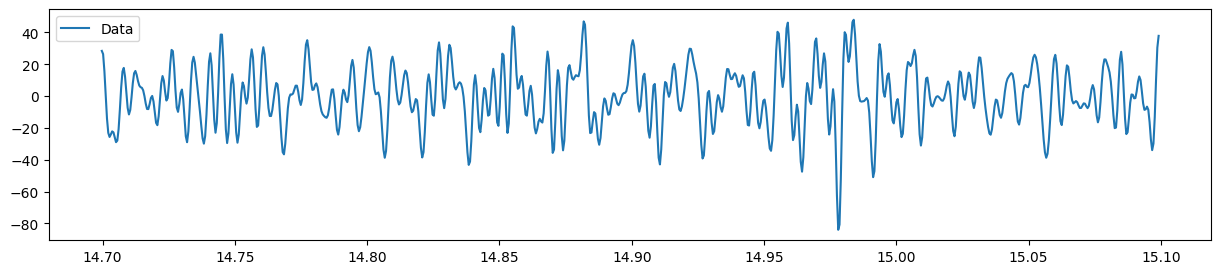

In [25]:
pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times-t0, white_data, label="Data")
#pylab.plot(white_template.sample_times-t0, white_template, label="Template")
pylab.legend()
pylab.show()

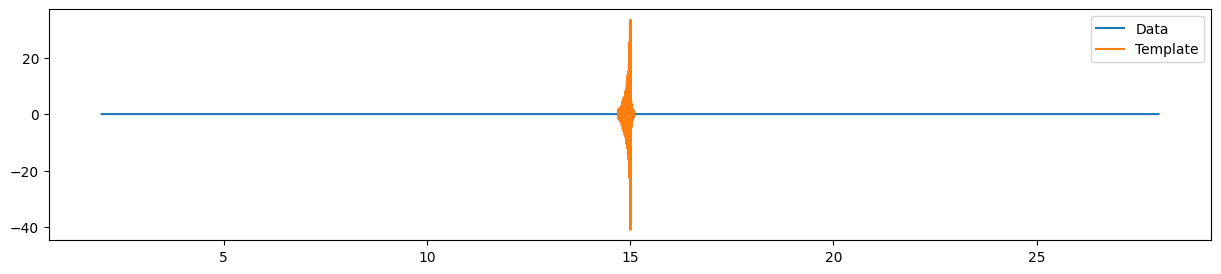

In [14]:
pylab.figure(figsize=[15, 3])
pylab.plot(aligned.sample_times-t0, aligned, label="Data")
pylab.plot(white_template.sample_times-t0, white_template, label="Template")
pylab.legend()
pylab.show()

/tmp/ipykernel_163/876522656.py:15: RuntimeWarning: invalid value encountered in sqrt
  pylab.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)


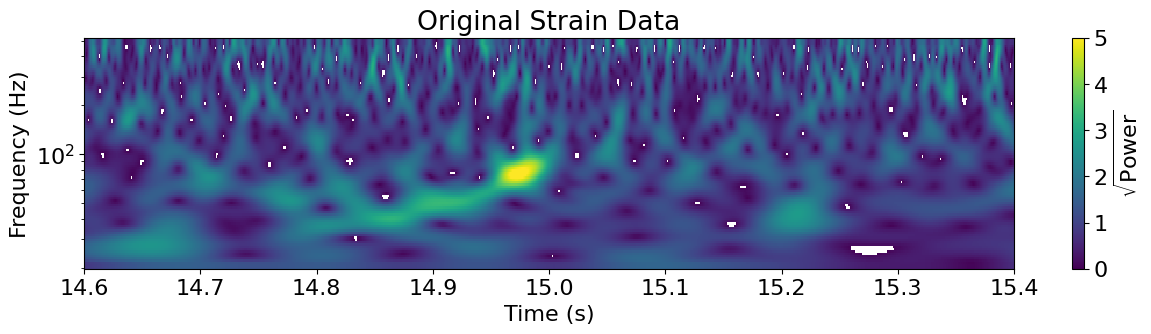

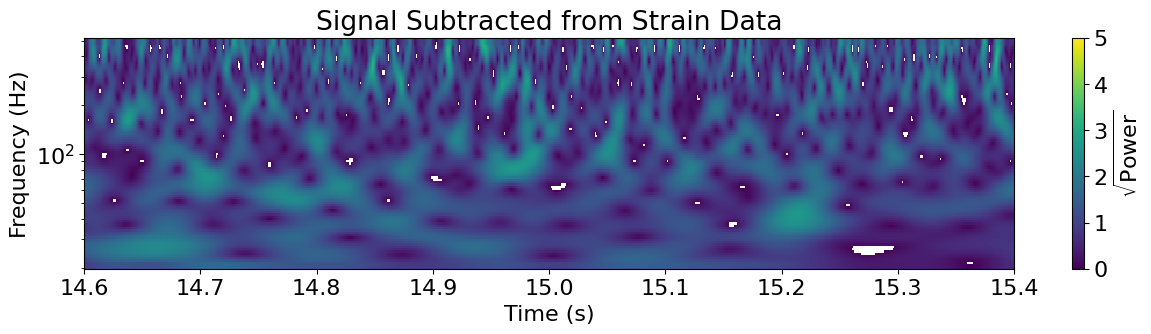

In [48]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original Strain Data'),
                    (subtracted, 'Signal Subtracted from Strain Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    time = 15
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    time = 15
    pylab.xlim(time - 0.4, time + 0.4)
    pylab.colorbar(label='$\sqrt{\mathrm{Power}}$')
    pylab.show()

/tmp/ipykernel_717/2372564640.py:12: RuntimeWarning: invalid value encountered in sqrt
  newp = p.reshape(-1, t.shape[0])**0.5


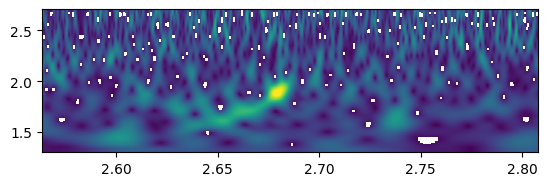

In [54]:
strain = ts# - sine(ts.sample_times, *popt)

strain = resample_to_delta_t(highpass(strain, 20), 1.0/2048)

conditioned = strain.crop(2,2)

t, f, p = conditioned.whiten(4, 4).qtransform(.001,
                                        logfsteps=100,
                                        qrange=(8, 8),
                                        frange=(20, 512))

newp = p.reshape(-1, t.shape[0])**0.5

plt.imshow(newp[:,10500:11500], aspect=1/20, origin='lower', vmax=5, extent = [ts.sample_times[10500]-t0, ts.sample_times[11500]-t0, np.log10(20), np.log10(512)])

In [37]:
np.array(ts.sample_times)

array([0.00000000e+00, 2.44140625e-04, 4.88281250e-04, ...,
       2.99992676e+01, 2.99995117e+01, 2.99997559e+01])

In [38]:
df.t

0         27.000000
1         27.000244
2         27.000488
3         27.000732
4         27.000977
            ...    
122875    56.998779
122876    56.999023
122877    56.999268
122878    56.999512
122879    56.999756
Name: t, Length: 122880, dtype: float64

## Old Tutorial Stuff - 

#### make your signal model

Conceptually, matched filtering involves laying the potential signal over your data and integrating (after weighting frequencies correctly). If there is a signal in the data that aligns with your 'template', you will get a large value when integrated over.

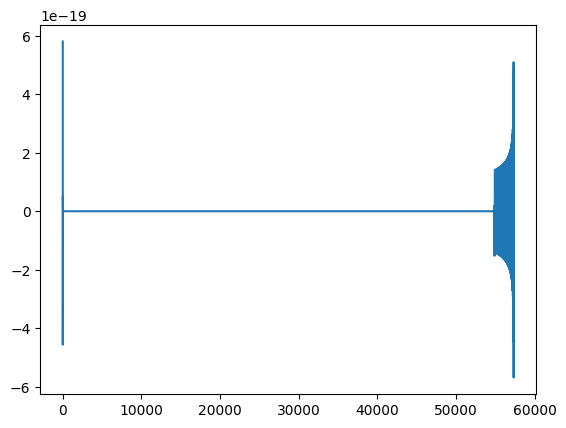

In [14]:
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, which is within the posterior probability
# of GW150914. 
m = 25 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp.resize(len(conditioned))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.show()

#### calculating the signal-to-noise time series

In this section we will now calculate the signal-to-noise time series for our template. We'll take care to handle issues of filter corruption / wraparound by truncating the output time series. We need to account for both the length of the template and 1 / PSD.

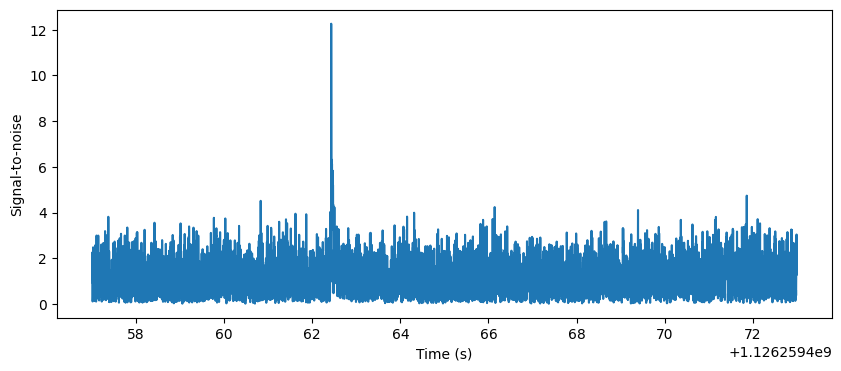

We found a signal at 1126259462.4291992s with SNR 12.26702651071141


In [15]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

### Aligning and Subtracting the Proposed Signal

In the previous section we ound a peak in the signal-to-noise for a proposed binary black hole merger. We can use this SNR peak to align our proposal to the data, and to also subtract our proposal from the data.

In [16]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

#### Visualize the overlap between the signal and data

To compare the data an signal on equal footing, and to concentrate on the frequency range that is important. We will whiten both the template and the data, and then bandpass both the data and template between 30-300 Hz. In this way, any signal that is in the data is transformed in the same way that the template is.

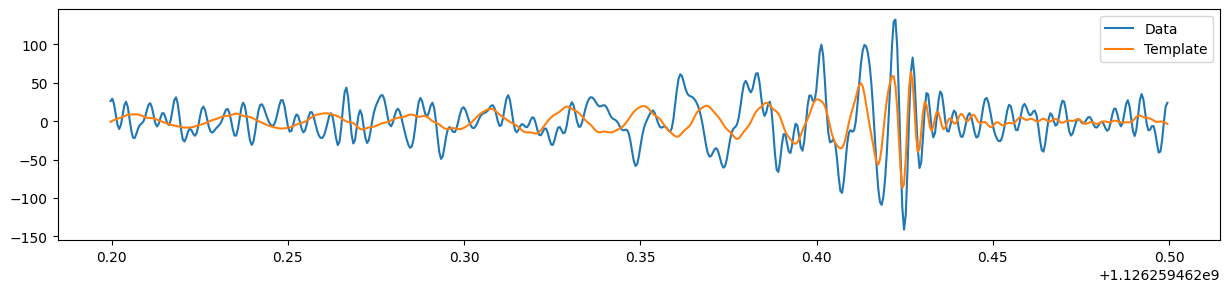

In [17]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

#### Subtracting the signal from the data

Now that we've aligned the template we can simply subtract it. Let's see below how that looks in the time-frequency plots!

/tmp/ipykernel_337/3726468914.py:14: RuntimeWarning: invalid value encountered in sqrt
  pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)


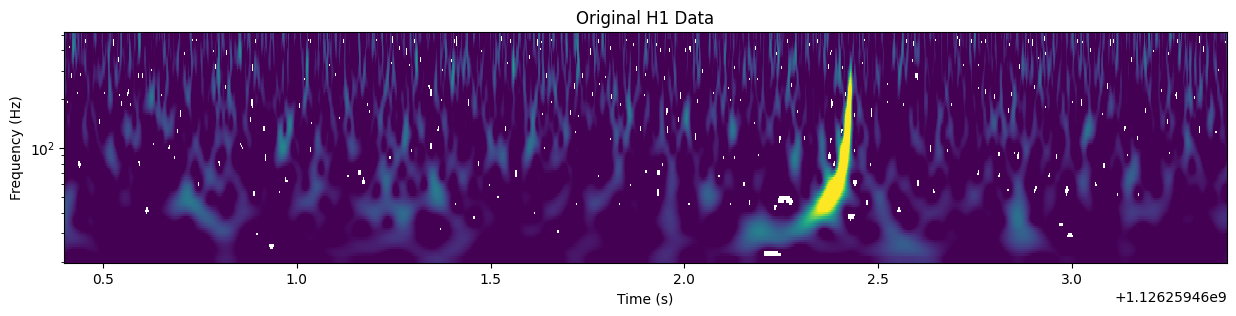

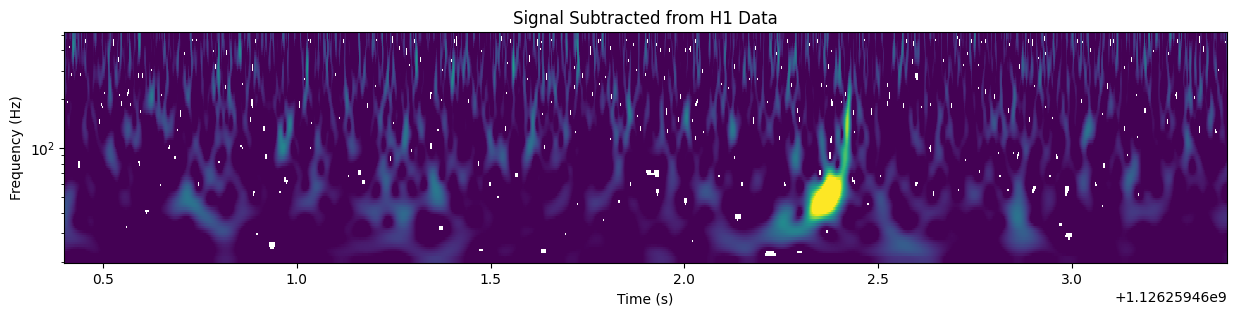

In [18]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()

## Challenge!

Use the methods demonstrated above to see if you can calculate the SNR
time series in the following data sets. What is the SNR of each signal?
Which template matched which data?

Information that may be useful:

* Signals are all placed between 100 and 120 seconds into the frame file.
* You may assume mass1 = mass2 (equal mass) and that each component mass is one of 22, 36, or 50.
* Each file starts at gps time 0, and ends at gps time 128
* The channel name in each file is "H1:TEST-STRAIN"

In [9]:
import pycbc.frame
import pylab
# example of reading the strain in (note this is the same as in PyCBC tutorial 1)
ts = pycbc.frame.query_and_read_frame('det3.gwf', 'K1:FAKE_STRAIN', 100,200)
pylab.plot(ts.sample_times, ts)



ValueError: Failed to determine default gwdatafind host, please pass manually or set the `GWDATAFIND_SERVER` environment variable

In [6]:
from pycbc.frame.frame import locations_to_cache

ff = locations_to_cache(['det3.gwf'])

In [7]:
ff

<Swig Object of type 'LALCache *' at 0x7f89940e4d30>

In [22]:
f = open('det3.gwf')
f.read()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xef in position 18: invalid continuation byte

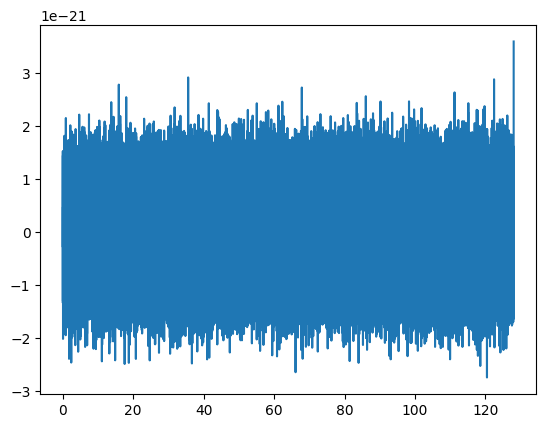

In [20]:
import pycbc.frame

# example of reading the strain in (note this is the same as in PyCBC tutorial 1)
ts = pycbc.frame.read_frame('PyCBC_T2_1.gwf', 'H1:TEST-STRAIN', 0, 128)
pylab.plot(ts.sample_times, ts)
pylab.show()

In [7]:
# Download the challenge set files
from six.moves.urllib import request

def get_file(fname):
    url = "https://github.com/ahnitz/odw-storage/raw/master/{}"
    url = url.format(fname)
    request.urlretrieve(url, fname)
    print('Getting : {}'.format(url))

files = ['PyCBC_T2_0.gwf', 'PyCBC_T2_1.gwf', 'PyCBC_T2_2.gwf',
         'PyCBC_T2_3.gwf', 'PyCBC_T2_4.gwf']

for fname in files:
    get_file(fname)

Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_0.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_1.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_2.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_3.gwf
Getting : https://github.com/ahnitz/odw-storage/raw/master/PyCBC_T2_4.gwf
